In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
import math
from sklearn.preprocessing import minmax_scale

plt.rcParams.update({'font.size': 12})

In [2]:
# import dataset
df_train = pd.read_csv('data/train.csv', delimiter=',', decimal='.')

df_train['time'] = pd.to_datetime(df_train['time'], errors='coerce')

df_train.set_index('time', inplace=True)

df_train.info() # all columns are full except snow and demand

# summer / winter time change isn't a problem, because timezone info is included

<class 'pandas.core.frame.DataFrame'>
Index: 8424 entries, 2021-09-01 00:00:00+03:00 to 2022-08-17 23:00:00+03:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    8424 non-null   float64
 1   dwpt    8424 non-null   float64
 2   rhum    8424 non-null   float64
 3   snow    119 non-null    float64
 4   wdir    8424 non-null   float64
 5   wspd    8424 non-null   float64
 6   wpgt    8424 non-null   float64
 7   pres    8424 non-null   float64
 8   price   8424 non-null   float64
 9   demand  8338 non-null   float64
dtypes: float64(10)
memory usage: 723.9+ KB


/tmp/ipykernel_63081/3638150935.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_train['time'] = pd.to_datetime(df_train['time'], errors='coerce')


In [3]:
# import dataset
df_test = pd.read_csv('data/test.csv', delimiter=',', decimal='.')

df_test.set_index('time', inplace=True)

df_test.info() # all columns are full except snow

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 2022-08-18 00:00:00+03:00 to 2022-08-24 23:00:00+03:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    168 non-null    float64
 1   dwpt    168 non-null    float64
 2   rhum    168 non-null    float64
 3   snow    0 non-null      float64
 4   wdir    168 non-null    float64
 5   wspd    168 non-null    float64
 6   wpgt    168 non-null    float64
 7   pres    168 non-null    float64
 8   price   168 non-null    float64
 9   demand  168 non-null    float64
dtypes: float64(10)
memory usage: 14.4+ KB


# Clean Data

Search for missing rows and fill them.

Will the summer/winter time make a problem?

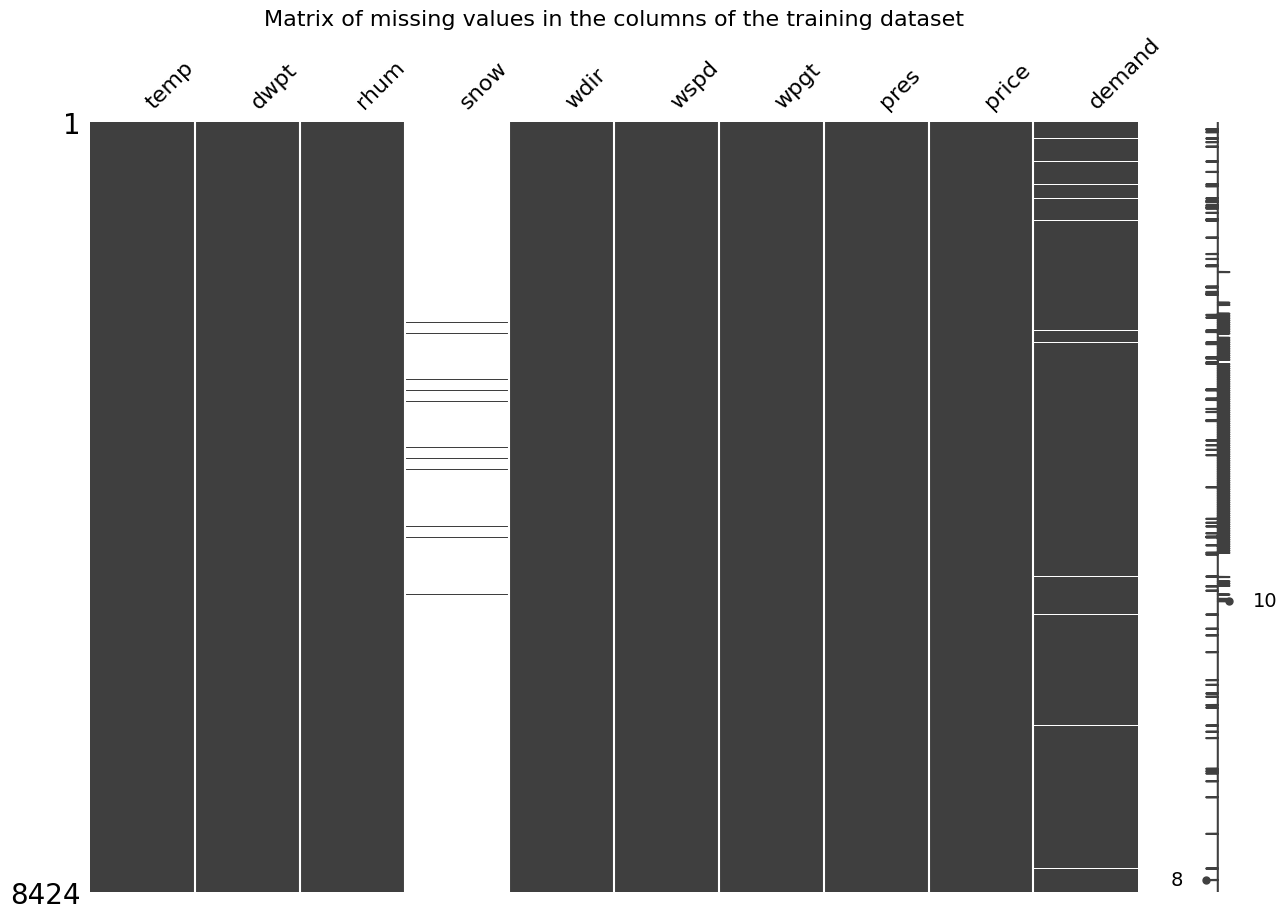

In [4]:
import missingno as msno

#overview of missing values
msno.matrix(df_train, figsize=(15,10))
plt.title("Matrix of missing values in the columns of the training dataset", fontsize=16)
plt.savefig("diagrams/matrix_missing_values.pdf")

In [5]:
no_demand = df_train[df_train['demand'].isnull()]

print(no_demand.mean())
print(df_train.mean())

# looks like missing at random (no abhängigkeiten)



temp         5.390698
dwpt         1.132558
rhum        76.976744
snow       200.000000
wdir       201.860465
wspd         9.104651
wpgt        20.216279
pres      1015.467442
price        0.158745
demand            NaN
dtype: float64
temp         6.435708
dwpt         2.228359
rhum        77.191121
snow        78.319328
wdir       202.886633
wspd         9.132918
wpgt        20.931588
pres      1013.128063
price        0.156541
demand       1.055267
dtype: float64


In [6]:
snow = df_train[df_train['snow'].notnull()]

print("Max temperature: ", snow['temp'].max())
print(df_train['snow'].describe())

print(snow.mean())
print(df_train.mean())

# missing a lot of values, especially if it was zero -> delete column (not needed)

Max temperature:  3.9
count    119.000000
mean      78.319328
std       63.129130
min        0.000000
25%       20.000000
50%       60.000000
75%      130.000000
max      220.000000
Name: snow, dtype: float64
temp        -3.273950
dwpt        -5.026050
rhum        88.033613
snow        78.319328
wdir       208.571429
wspd         9.166387
wpgt        20.684034
pres      1008.713445
price        0.196023
demand       1.018686
dtype: float64
temp         6.435708
dwpt         2.228359
rhum        77.191121
snow        78.319328
wdir       202.886633
wspd         9.132918
wpgt        20.931588
pres      1013.128063
price        0.156541
demand       1.055267
dtype: float64


In [7]:
# fill with mean

df_train['demand'].fillna(df_train['demand'].mean(), inplace=True)
df_train = df_train.drop(columns=['snow'])

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8424 entries, 2021-09-01 00:00:00+03:00 to 2022-08-17 23:00:00+03:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    8424 non-null   float64
 1   dwpt    8424 non-null   float64
 2   rhum    8424 non-null   float64
 3   wdir    8424 non-null   float64
 4   wspd    8424 non-null   float64
 5   wpgt    8424 non-null   float64
 6   pres    8424 non-null   float64
 7   price   8424 non-null   float64
 8   demand  8424 non-null   float64
dtypes: float64(9)
memory usage: 916.2+ KB


/tmp/ipykernel_63081/545505758.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['demand'].fillna(df_train['demand'].mean(), inplace=True)


Text(0, 0.5, 'Price [€]')

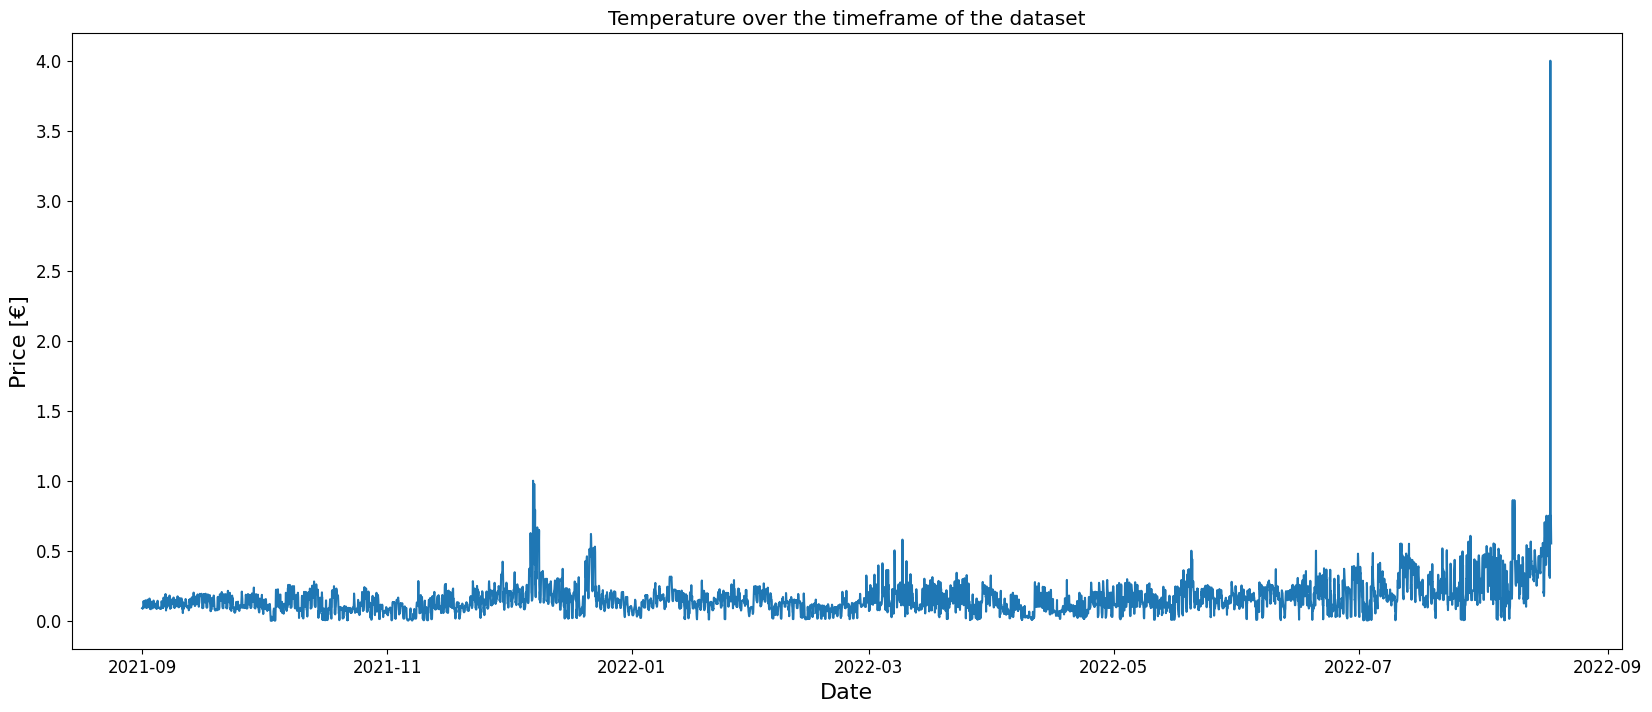

In [8]:
# statistics of data

# show temperature first
plt.figure(figsize=(20,8))
plt.title("Temperature over the timeframe of the dataset")
p = sns.lineplot(data=df_train['price'])
p.set_xlabel("Date", fontsize=16)
p.set_ylabel("Price [€]", fontsize=16)

In [9]:
# replace outlier with mean of previous and next price

max_ts = df_train['price'].idxmax()
max_idx = df_train.index.get_loc(max_ts)
df_train['price'][max_idx] = (df_train['price'][max_idx-1]+ df_train['price'][max_idx+1])/2
df_train['price'][max_idx]

/tmp/ipykernel_63081/3144267712.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_train['price'][max_idx] = (df_train['price'][max_idx-1]+ df_train['price'][max_idx+1])/2
/tmp/ipykernel_63081/3144267712.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in 

0.7500800000000001

Text(0, 0.5, 'Price [€]')

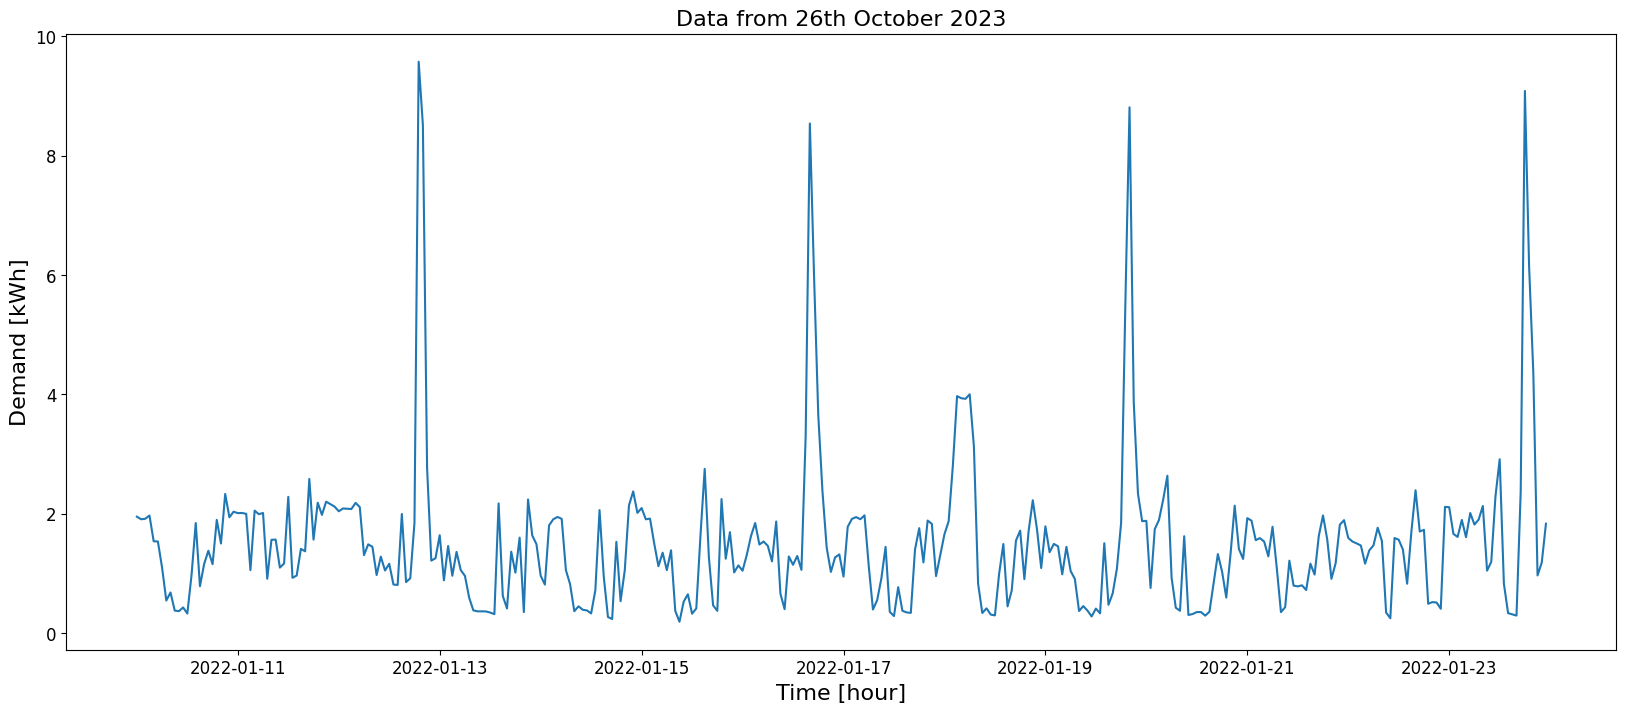

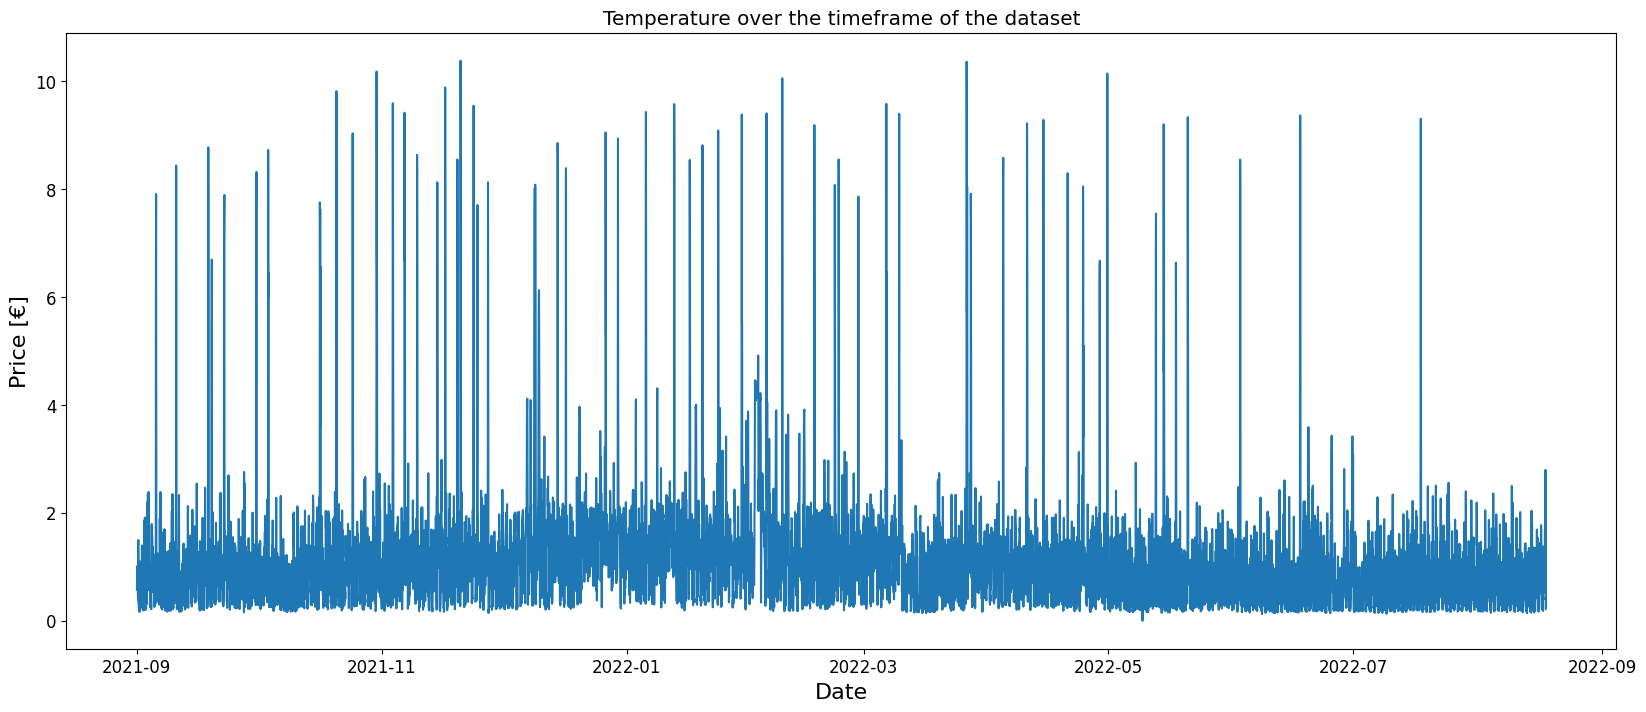

In [10]:
# check demand over two weeks
start_date = datetime(2022, 1,10, tzinfo=ZoneInfo("Europe/Tallinn"))
end_date = datetime(2022, 1, 24, tzinfo=ZoneInfo("Europe/Tallinn"))

df_week = df_train[(df_train.index >= start_date) & (df_train.index < end_date)]

plt.figure(figsize=(20,8))
plt.title("Data from 26th October 2023", fontsize=16)
p = sns.lineplot(data=df_week['demand'])
p.set_xlabel("Time [hour]", fontsize=16)
p.set_ylabel("Demand [kWh]", fontsize=16)

# show temperature first
plt.figure(figsize=(20,8))
plt.title("Temperature over the timeframe of the dataset")
p = sns.lineplot(data=df_train['demand'])
p.set_xlabel("Date", fontsize=16)
p.set_ylabel("Price [€]", fontsize=16)

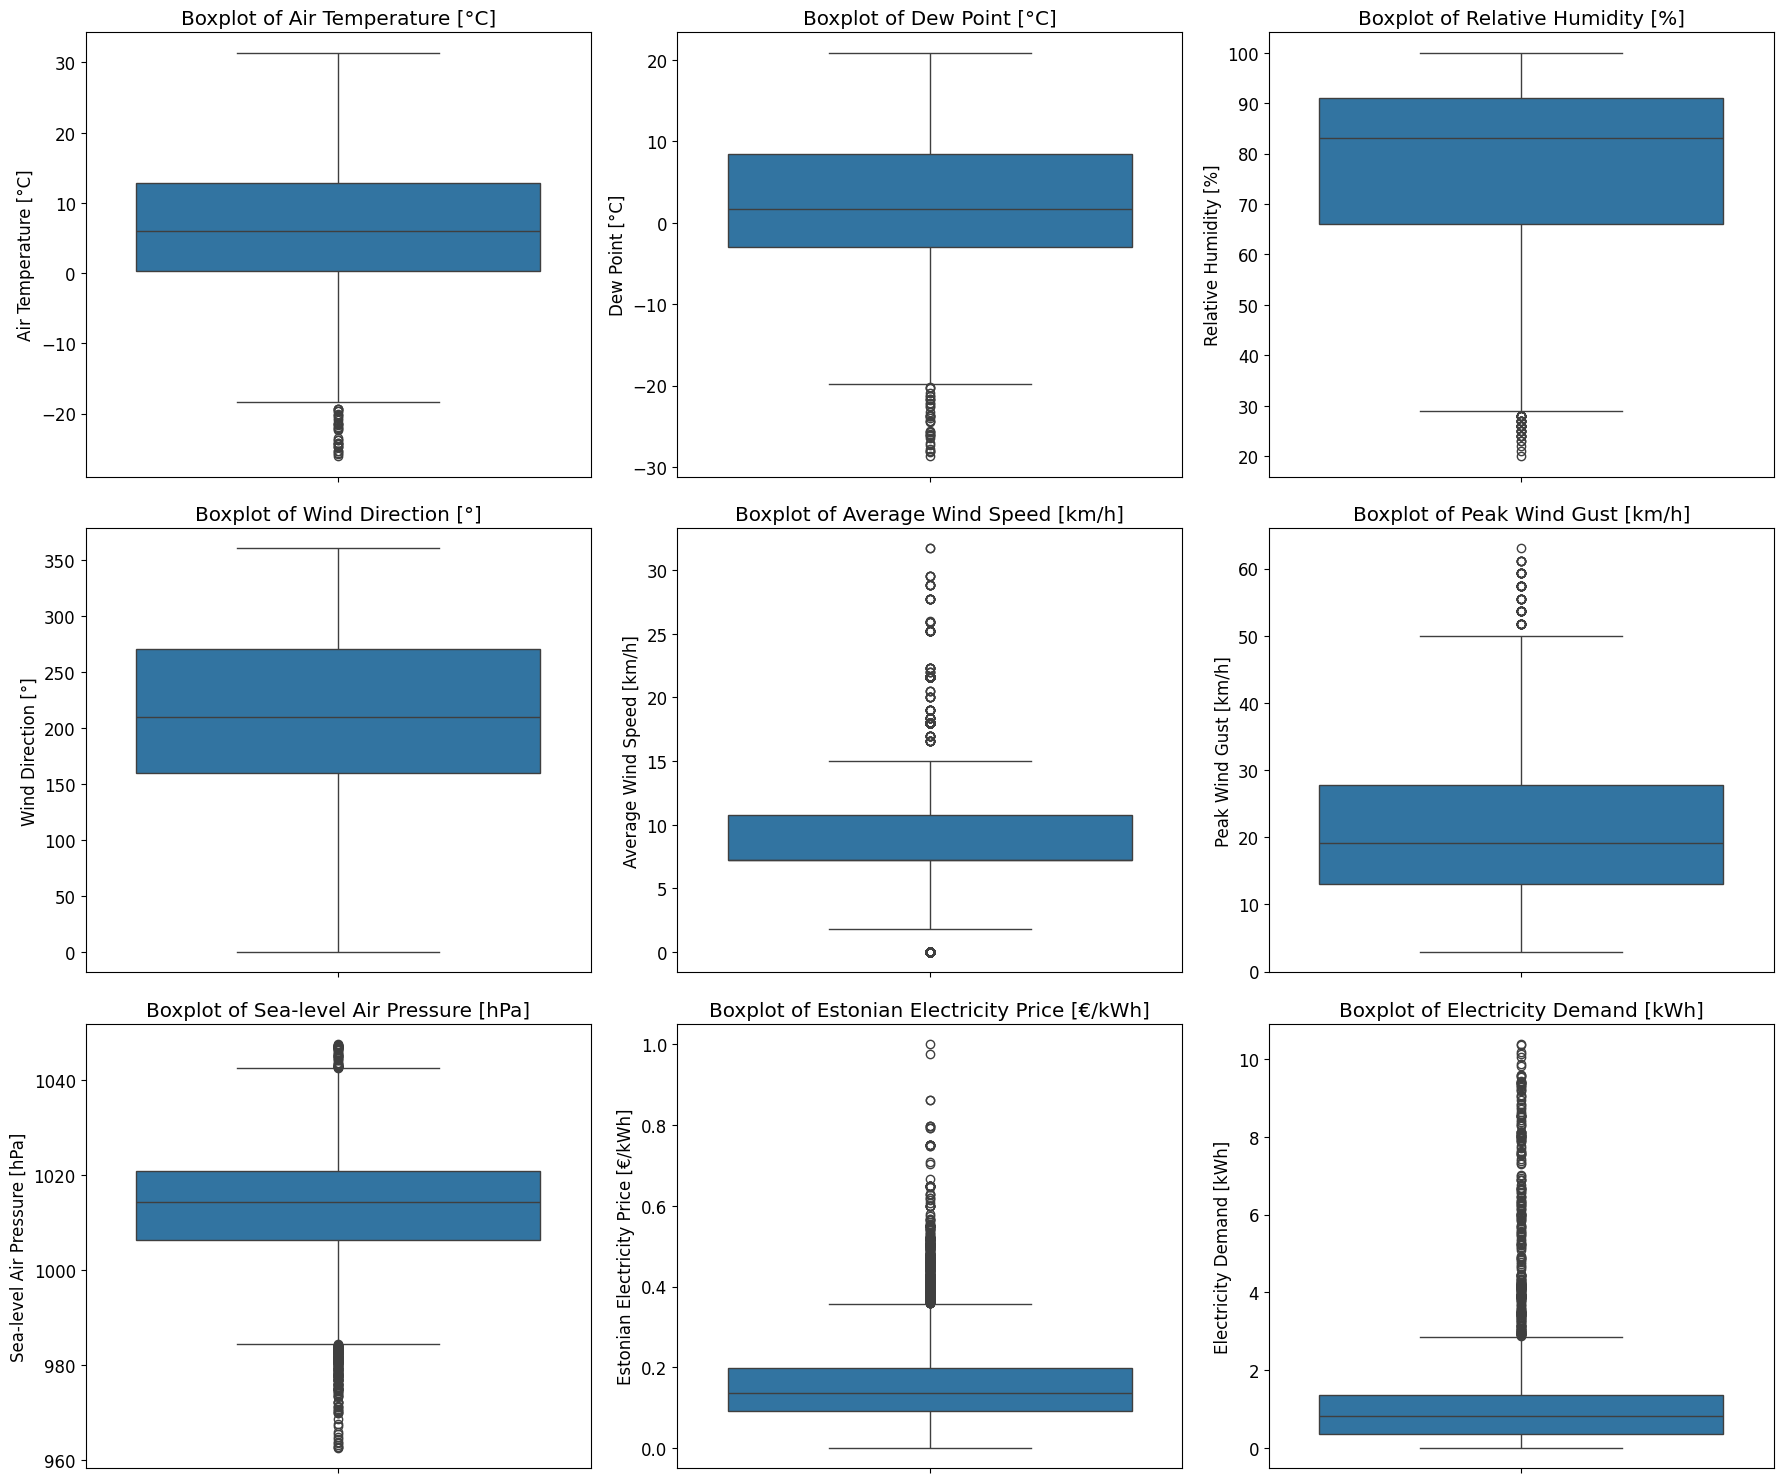

In [11]:
labels = {'temp': 'Air Temperature [°C]',
        'dwpt': 'Dew Point [°C]',
        'rhum': 'Relative Humidity [%]',
        'wdir': 'Wind Direction [°]',
        'wspd': 'Average Wind Speed [km/h]',
        'wpgt': 'Peak Wind Gust [km/h]',
        'pres': 'Sea-level Air Pressure [hPa]',
        'price': 'Estonian Electricity Price [€/kWh]',
        'demand': 'Electricity Demand [kWh]' }

# Set the number of columns you want for your subplots
ncols = 3
nrows = math.ceil(len(df_train.columns) / ncols)  # Calculate number of rows needed

# Create subplots with multiple columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each column and create a seaborn boxplot in each subplot
for i, col in enumerate(df_train.columns):
    sns.boxplot(data=df_train, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {labels[col]}')
    axes[i].set_ylabel(labels[col])

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.savefig("diagrams/boxplots_data.pdf")

## Analyze distribution of each variable

Build historgrams and look for normalized distribution.

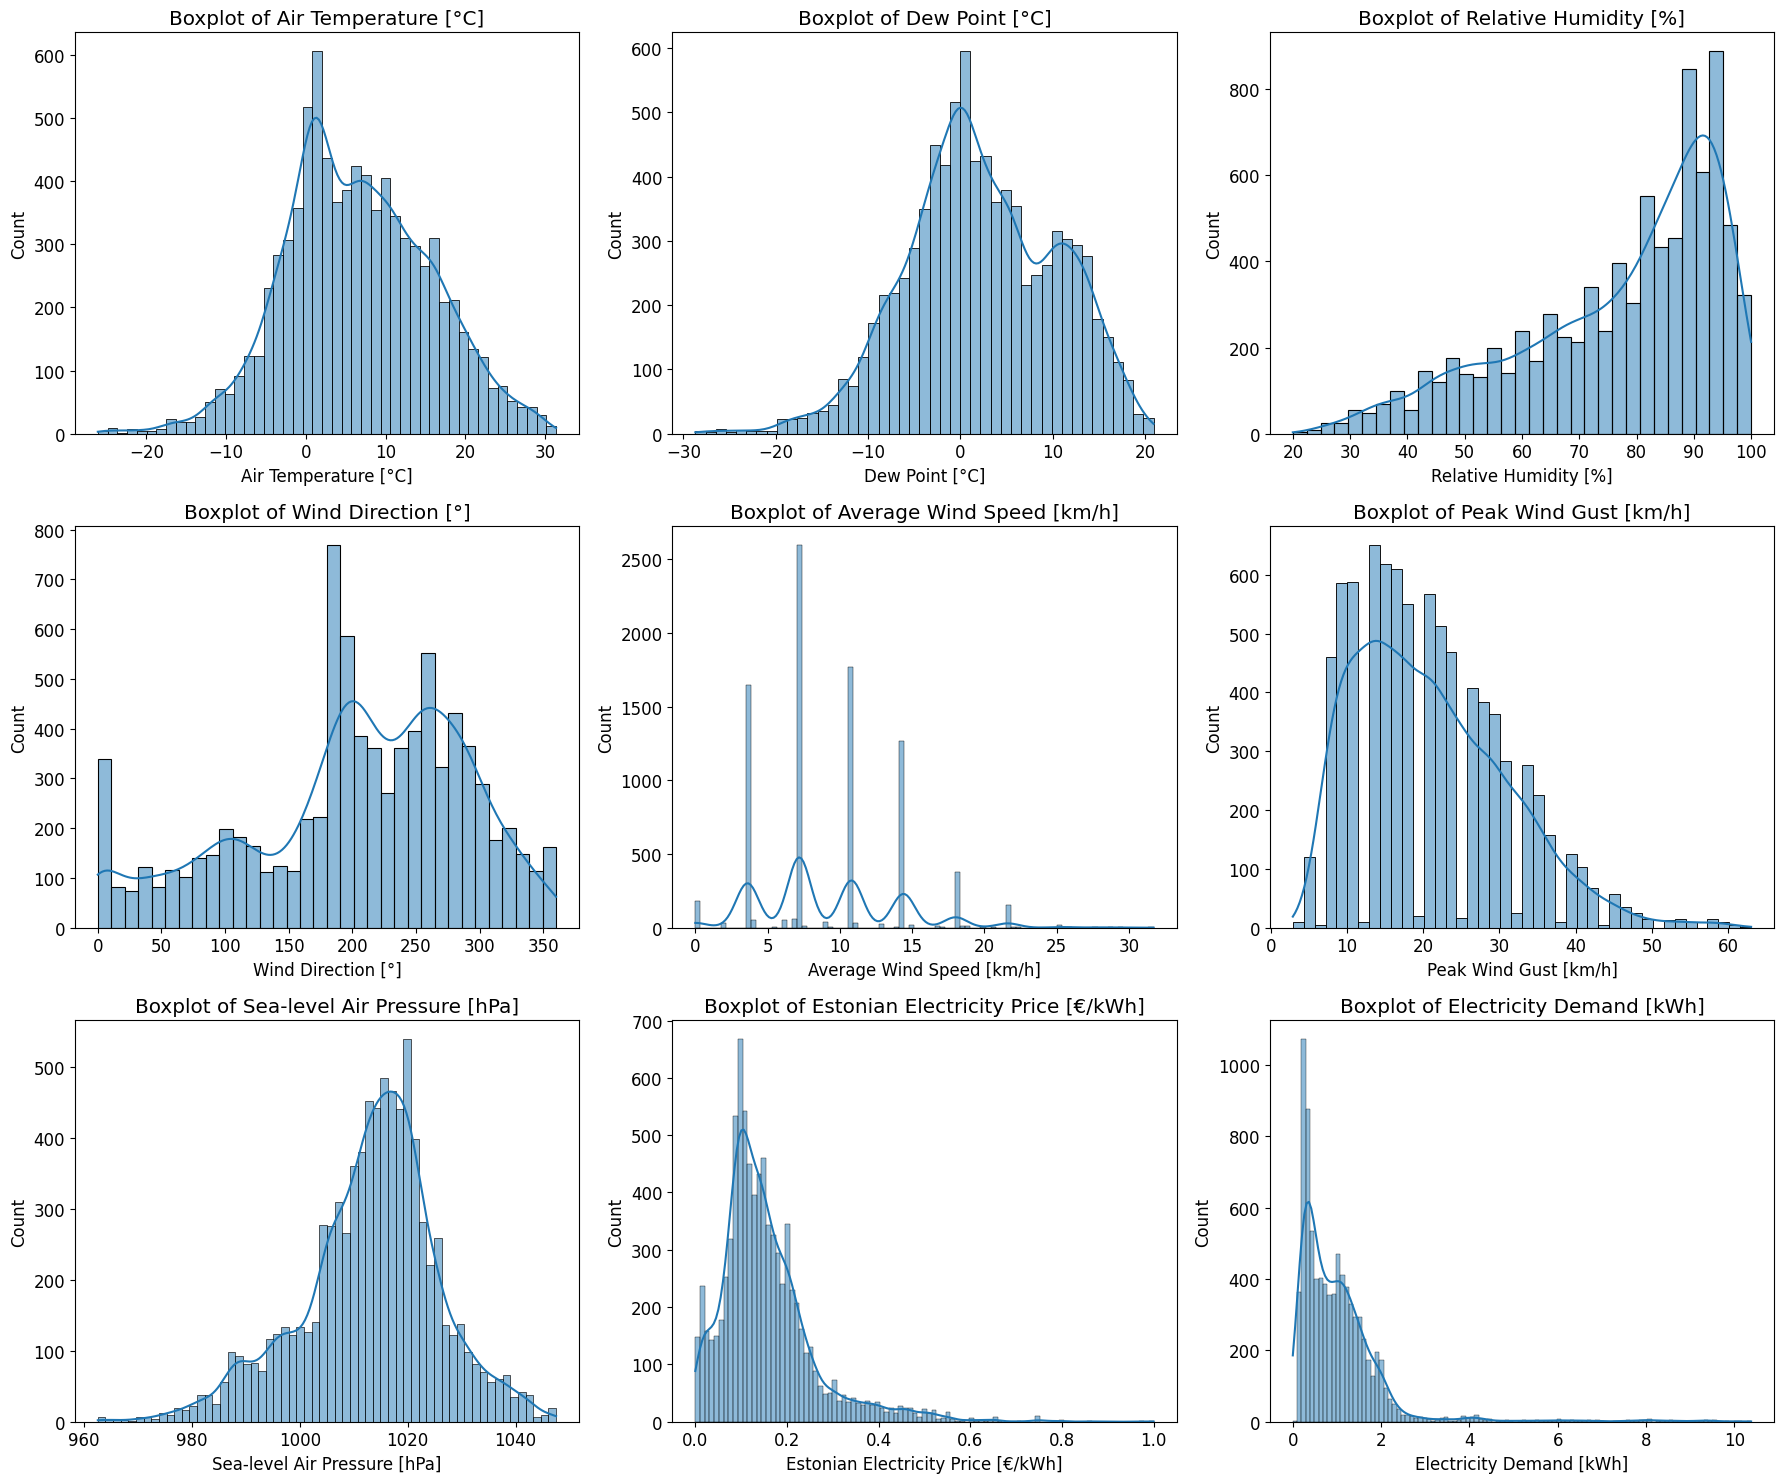

In [12]:
# Set the number of columns you want for your subplots
ncols = 3
nrows = math.ceil(len(df_train.columns) / ncols)  # Calculate number of rows needed

# Create subplots with multiple columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each column and create a seaborn boxplot in each subplot
for i, col in enumerate(df_train.columns):
    sns.histplot(data=df_train, x=col, ax=axes[i], kde=True)
    axes[i].set_title(f'Boxplot of {labels[col]}')
    axes[i].set_xlabel(labels[col])

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.savefig("diagrams/boxplots_data.pdf")

In [13]:
df_standard = df_train.copy()

# humidity is left-skewd
df_standard['rhum'] = np.pow(df_standard['rhum'].max() - df_standard['rhum'], 1/3)

# peal wind gust is right-skewd
df_standard['wpgt'] = np.pow(df_standard['wpgt'], 1/2)

# price is right skewd
df_standard['price'] = np.pow(df_standard['price'], 1/3)

# wind direction
df_standard['wdir'] = np.pow(df_standard['wdir'], 1/2)
df_standard['wdir'] = np.pow(df_standard['wdir'].max() - df_standard['wdir'], 1/2)

df_standard['price'] = minmax_scale(df_standard['price'])

# normalization

AttributeError: module 'numpy' has no attribute 'pow'

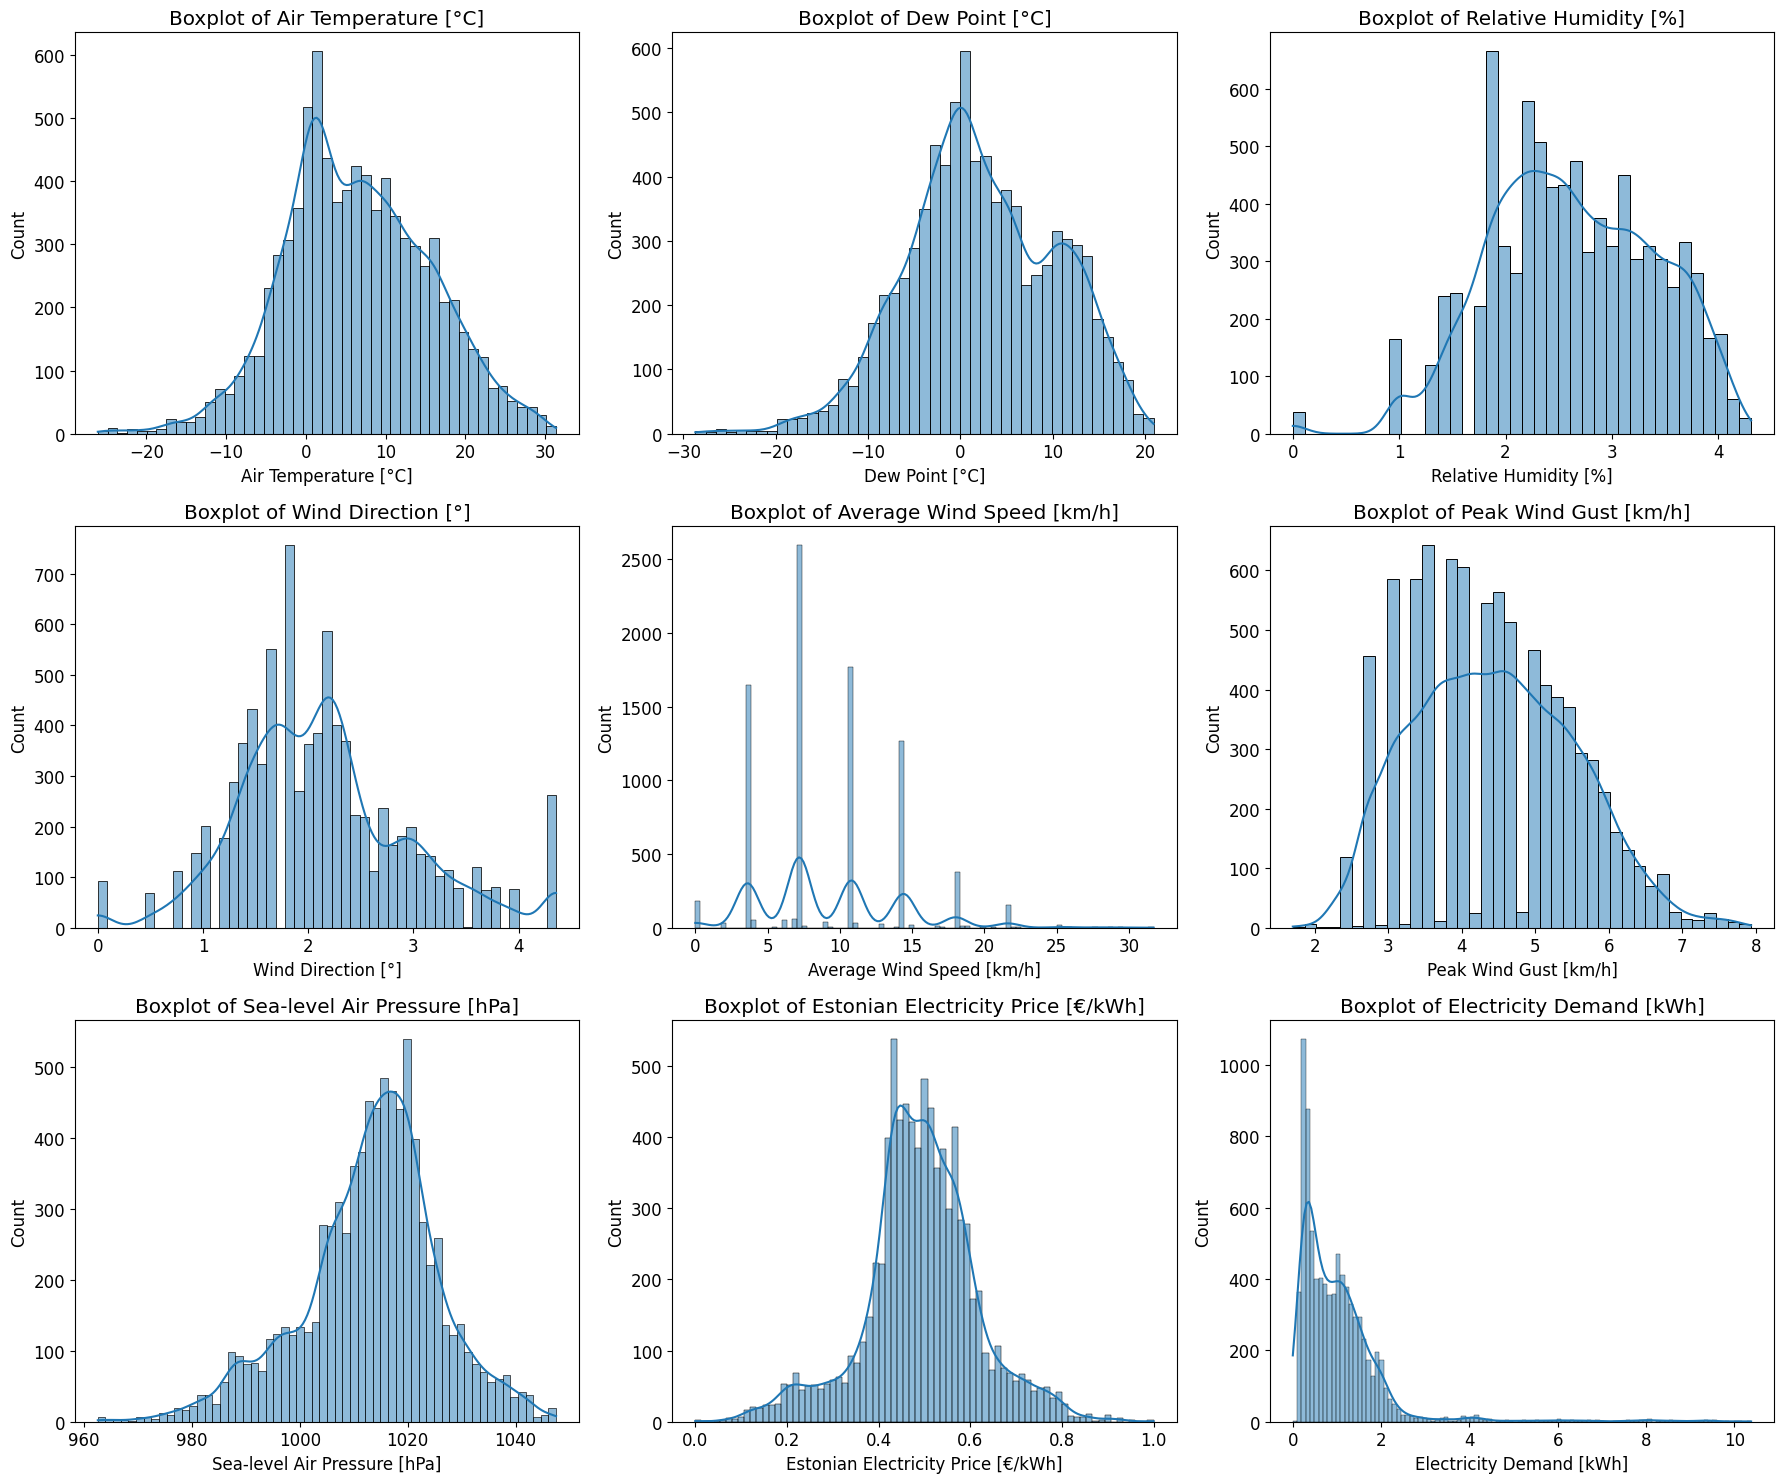

In [ ]:
# Set the number of columns you want for your subplots
ncols = 3
nrows = math.ceil(len(df_standard.columns) / ncols)  # Calculate number of rows needed

# Create subplots with multiple columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each column and create a seaborn boxplot in each subplot
for i, col in enumerate(df_standard.columns):
    sns.histplot(data=df_standard, x=col, ax=axes[i], kde=True)
    axes[i].set_title(f'Boxplot of {labels[col]}')
    axes[i].set_xlabel(labels[col])

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.savefig("diagrams/boxplots_data.pdf")

## New feature

Create new feature: is_weekend

In [ ]:
# here we are creating a new feature

## Ranking of features

By calculating the mutual information; Ranking is the decending order of scores

Text(0.5, 1.0, 'Mutual Information Scores')

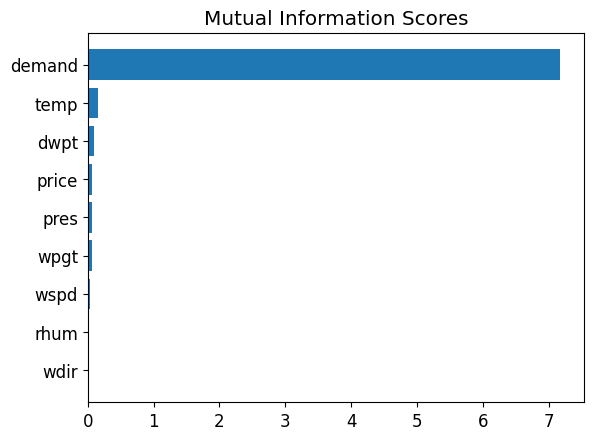

In [ ]:
from sklearn.feature_selection import mutual_info_regression

discrete_features = df_standard.dtypes == int

mi_scores = mutual_info_regression(df_standard, df_standard['demand'], discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=df_standard.columns)
mi_scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")


# Modelling

Goal: build a model to predict the demand

## Autoregressive model

First check if data is stationary and if not make it stationary


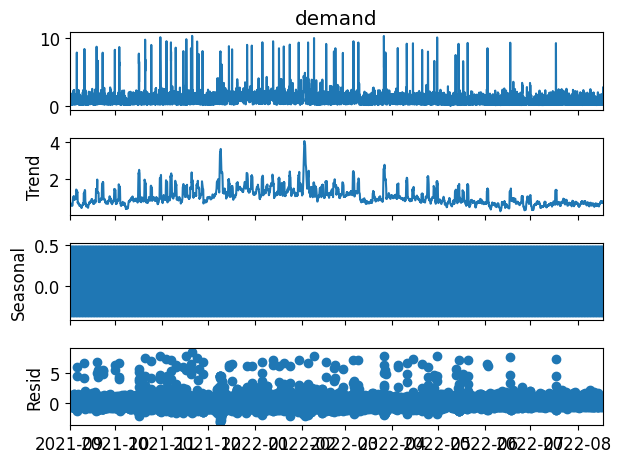

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df_train['demand'],model='additive',period=24)
decompose.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
fuller = adfuller(df_train['demand'])
print('ADF Statistic: %f' % fuller[0])
print('p-value: %f' % fuller[1])
print('Critical Values:')
for key, value in fuller[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.369470
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Demand over time is stationary (null hypothesis is rejected). 

Next ACF and PACF are created and analysed

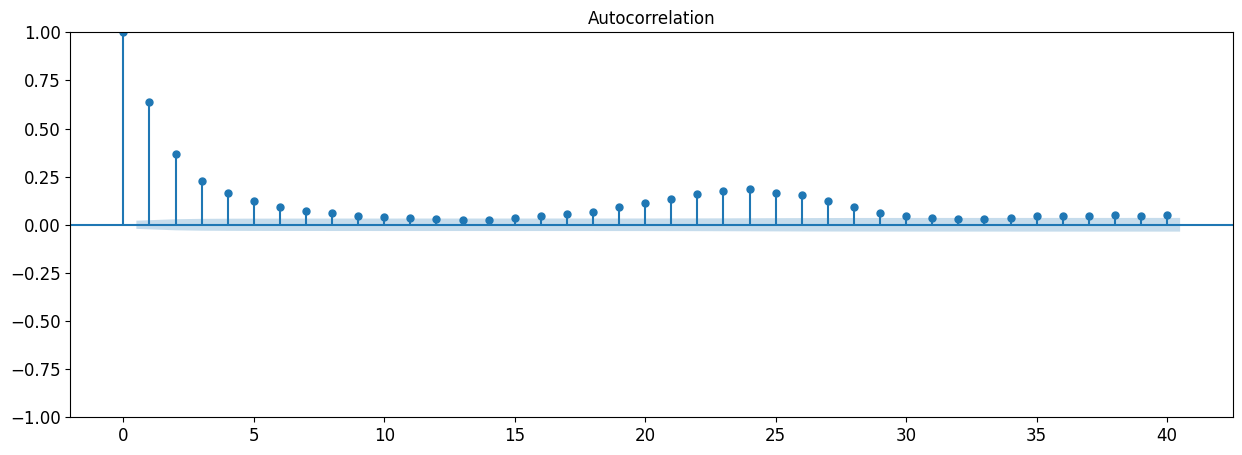

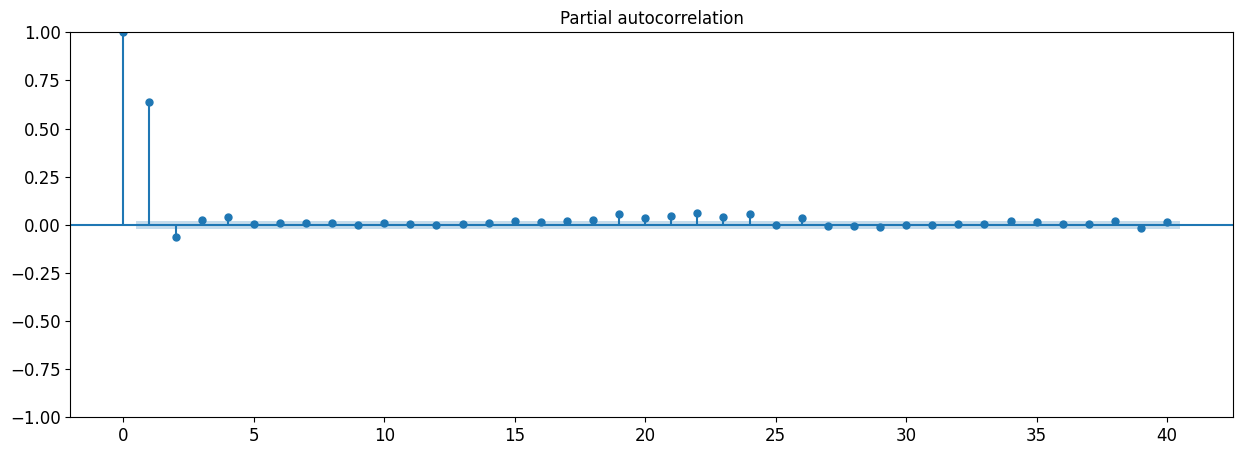

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# ACF
fig = plot_acf(df_train['demand'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title ('Autocorrelation', fontsize=12)
fig.set_size_inches((15, 5))

# PACF
fig = plot_pacf(df_train['demand'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Partial autocorrelation', fontsize=12)
fig.set_size_inches((15, 5))

# WHAT IS WITH DIFFERENCE? (@TODO)

In [14]:
print(f"NumPy version: {np.__version__}")
import pmdarima as pm
auto_arima = pm.auto_arima(df_train['demand'], stepwise=False, seasonal=False)
auto_arima

NumPy version: 1.26.4


ARIMA(order=(1, 1, 4), scoring_args={}, suppress_warnings=True)

DatetimeIndex(['2021-09-01 00:00:00+03:00', '2021-09-01 01:00:00+03:00',
               '2021-09-01 02:00:00+03:00', '2021-09-01 03:00:00+03:00',
               '2021-09-01 04:00:00+03:00', '2021-09-01 05:00:00+03:00',
               '2021-09-01 06:00:00+03:00', '2021-09-01 07:00:00+03:00',
               '2021-09-01 08:00:00+03:00', '2021-09-01 09:00:00+03:00',
               ...
               '2022-08-17 14:00:00+03:00', '2022-08-17 15:00:00+03:00',
               '2022-08-17 16:00:00+03:00', '2022-08-17 17:00:00+03:00',
               '2022-08-17 18:00:00+03:00', '2022-08-17 19:00:00+03:00',
               '2022-08-17 20:00:00+03:00', '2022-08-17 21:00:00+03:00',
               '2022-08-17 22:00:00+03:00', '2022-08-17 23:00:00+03:00'],
              dtype='datetime64[ns, Europe/Tallinn]', name='time', length=8424, freq='h')
ARMA(0,0,0) MAE = 0.6608408127956997
ARMA(0,0,1) MAE = 0.5666077326066834
ARMA(0,0,2) MAE = 0.5359949356889889
ARMA(0,0,3) MAE = 0.5272299335823688
ARMA(1,0,0) 

/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(2,0,3) MAE = 0.5092073974408771
ARMA(3,0,0) MAE = 0.5141797766281674


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3,0,1) MAE = 0.5046300642636867


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3,0,2) MAE = 0.5041329620007974


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3,0,3) MAE = 0.5009374357771322


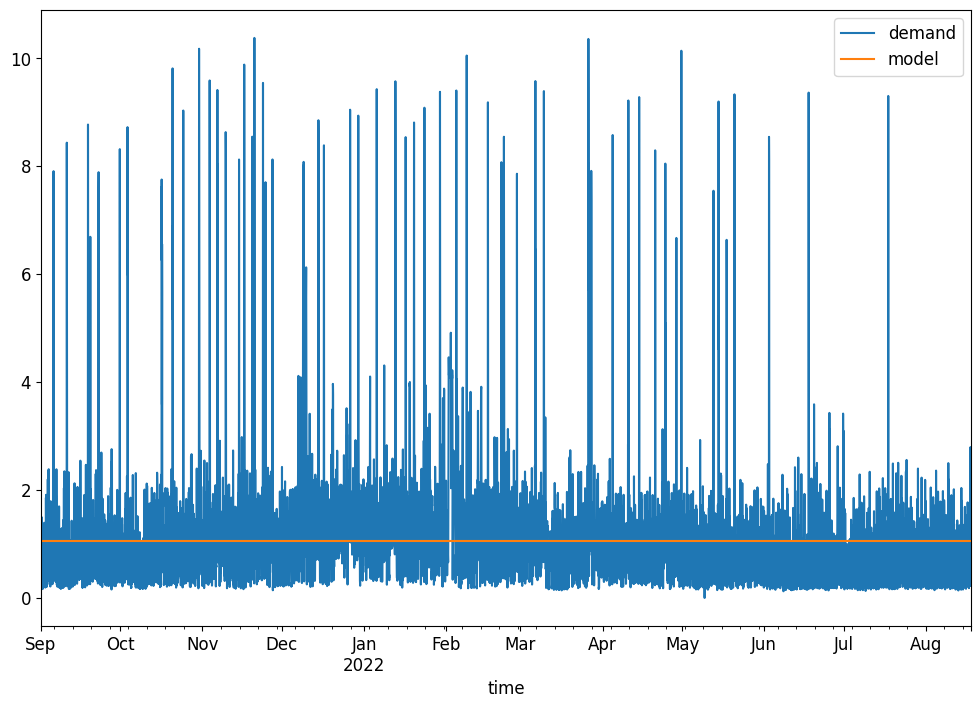

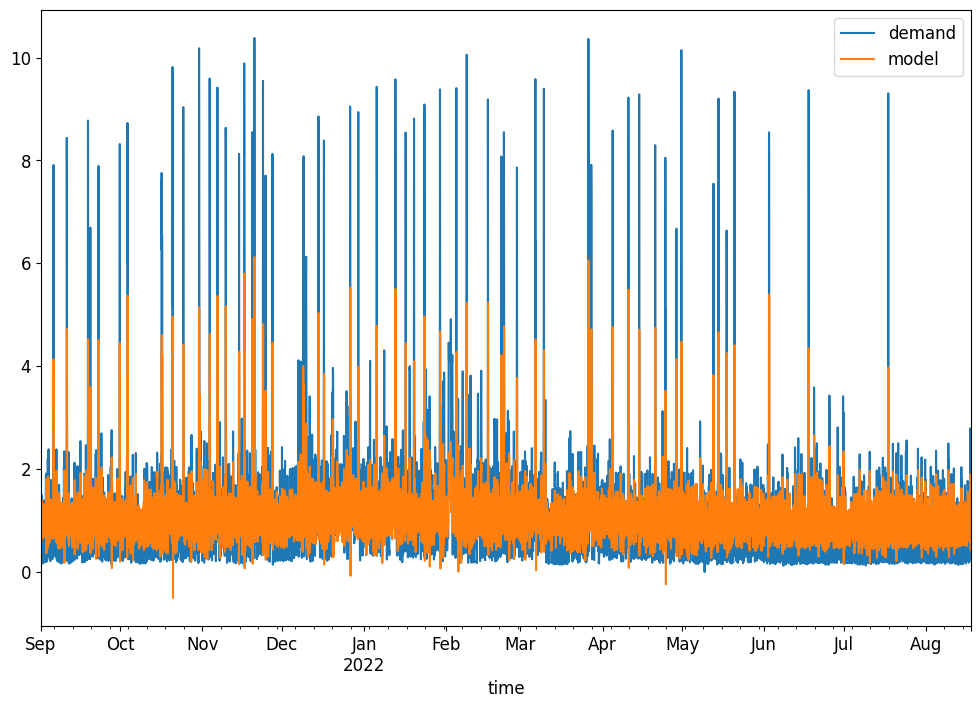

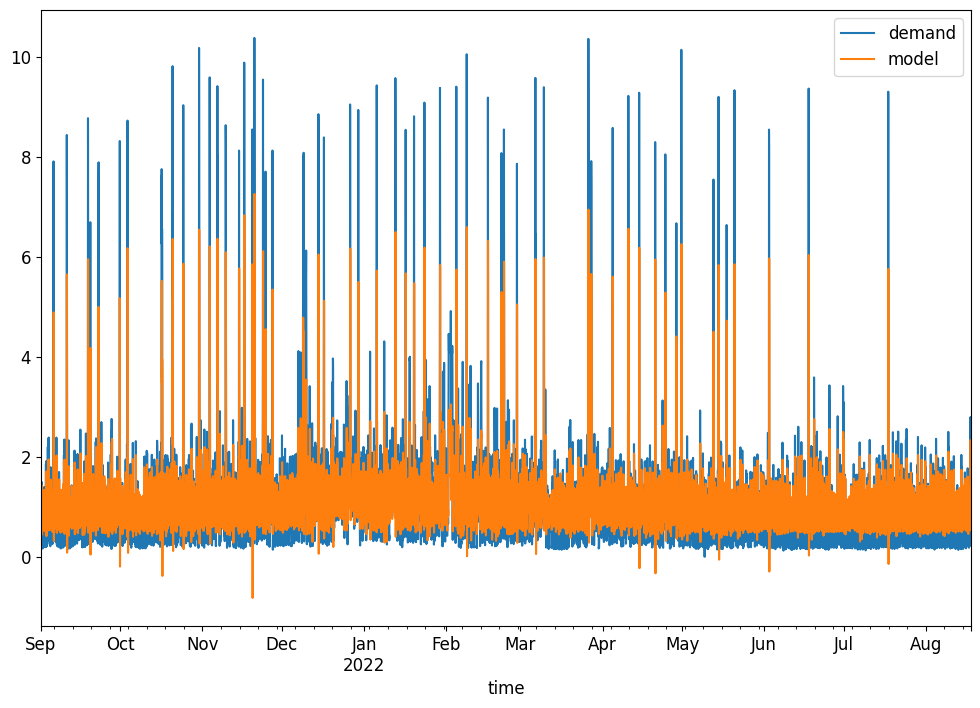

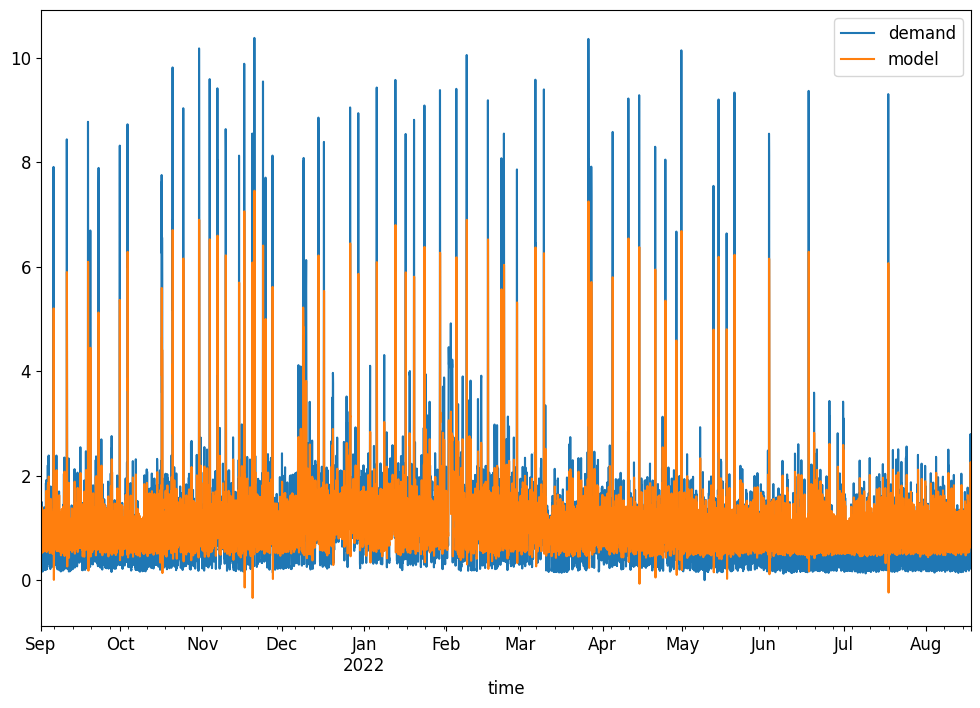

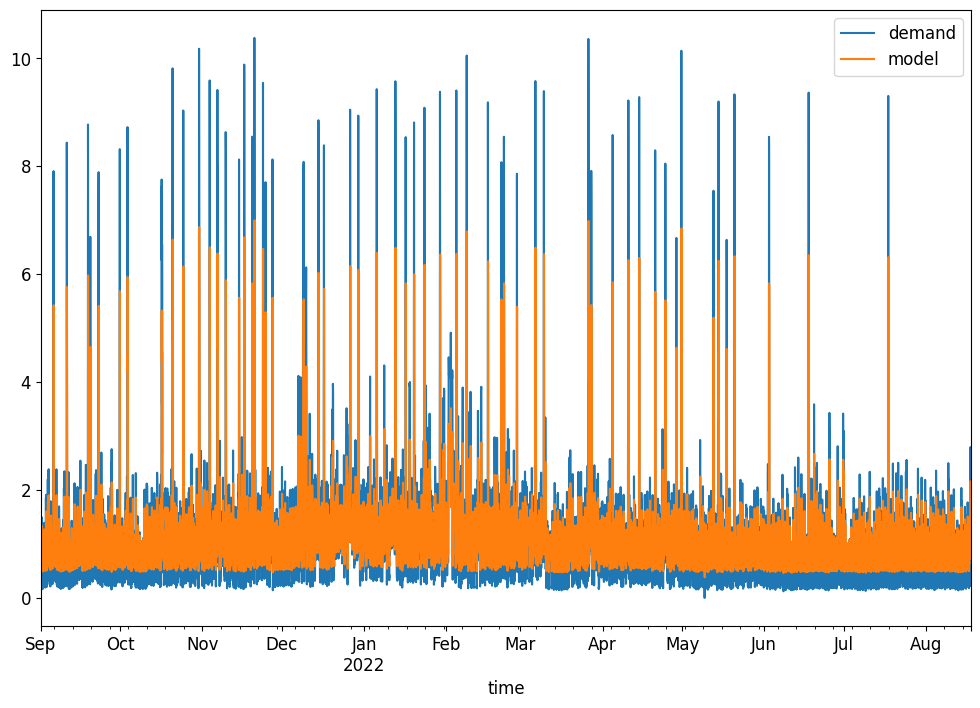

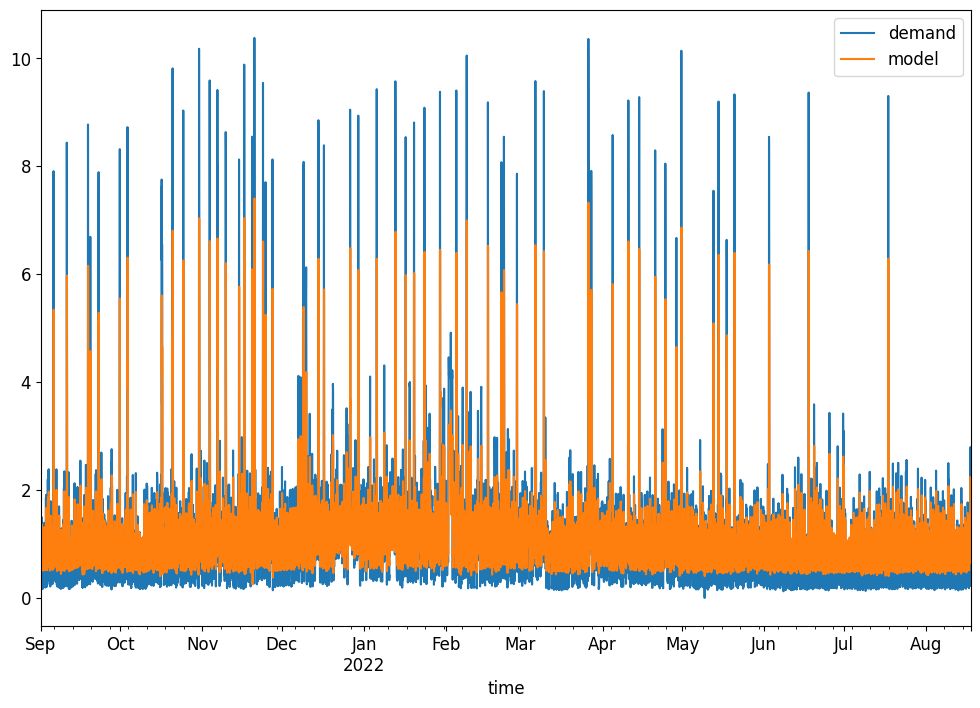

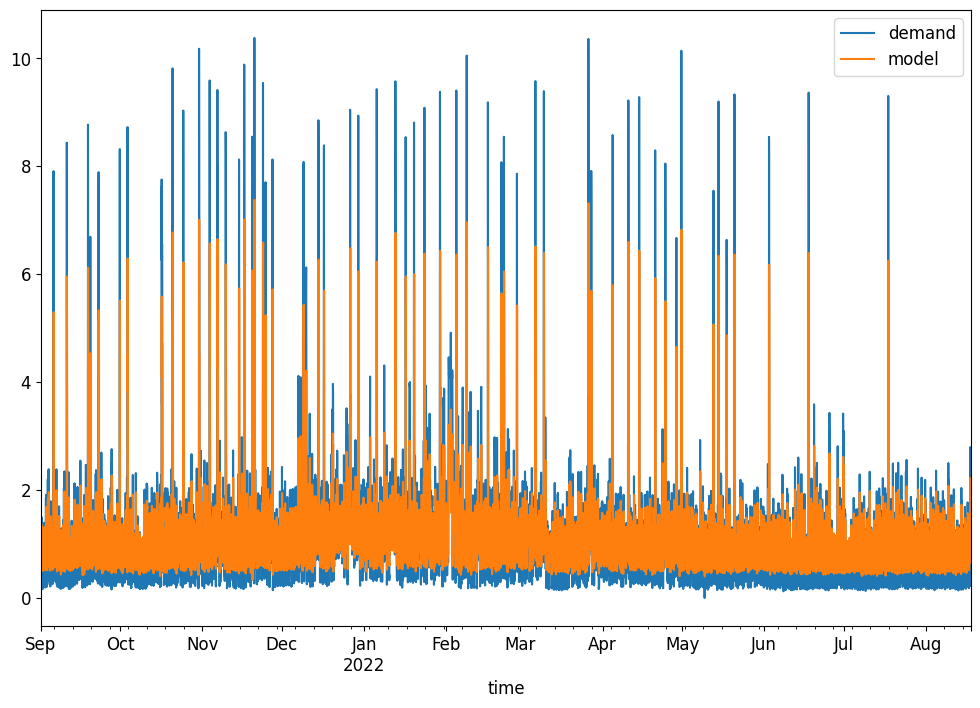

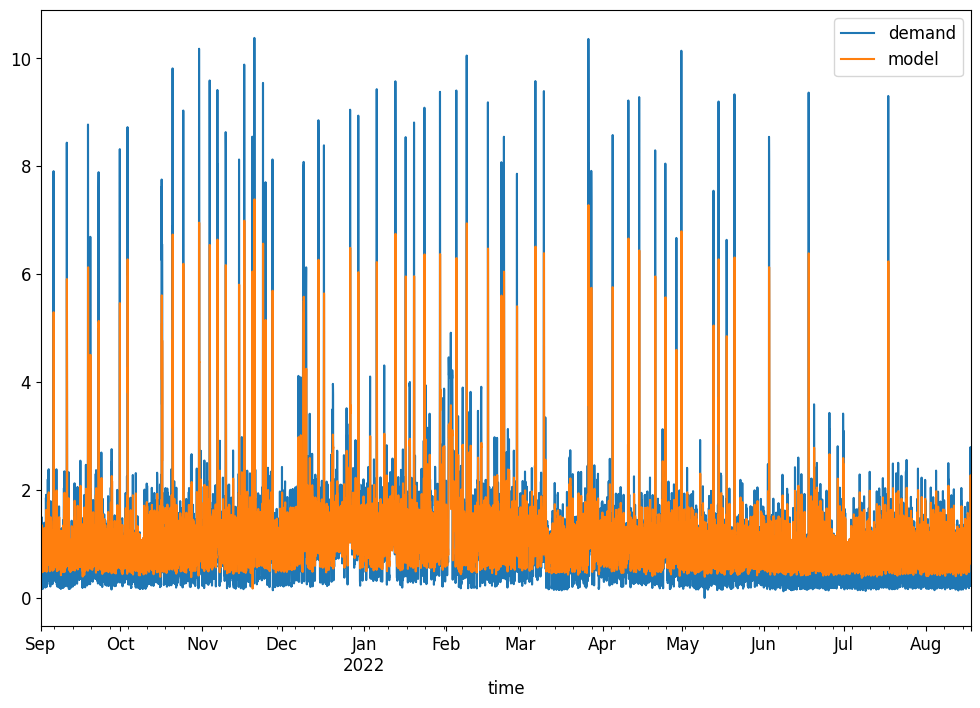

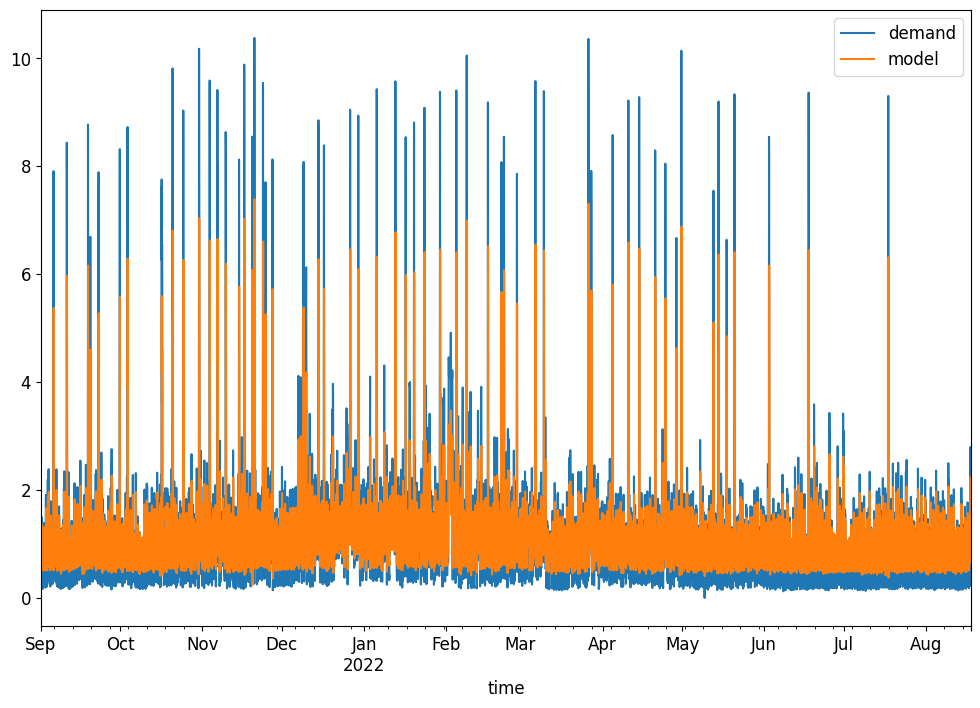

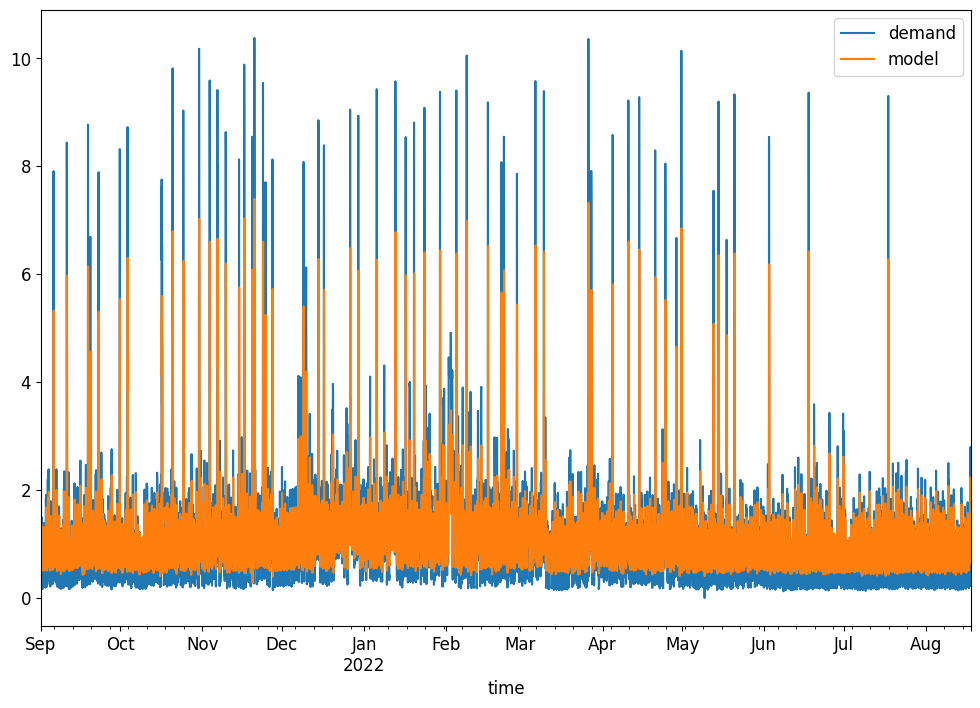

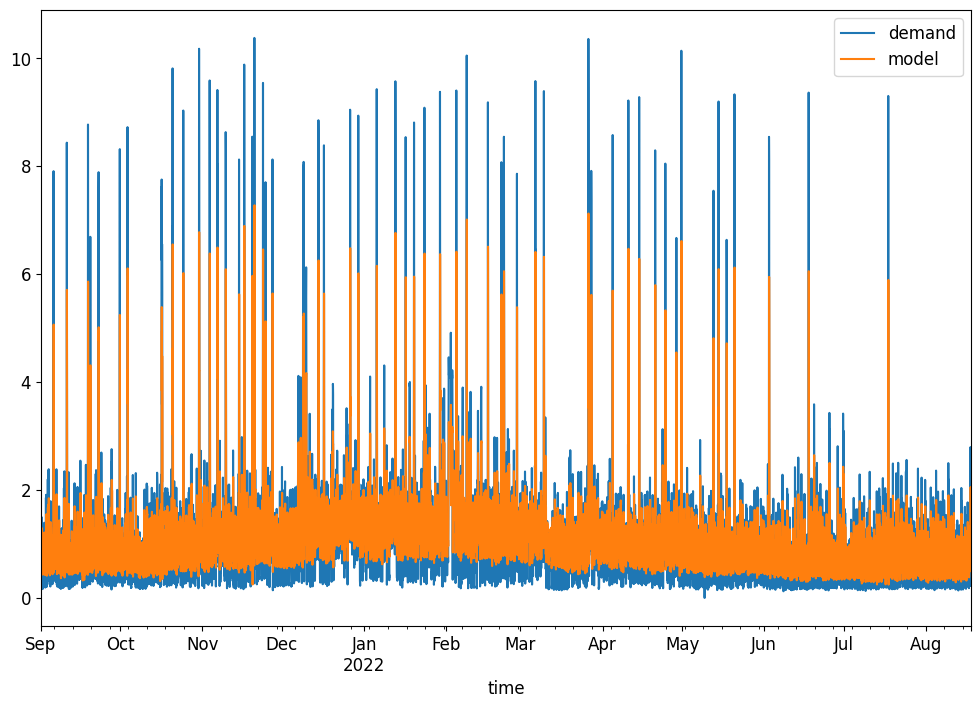

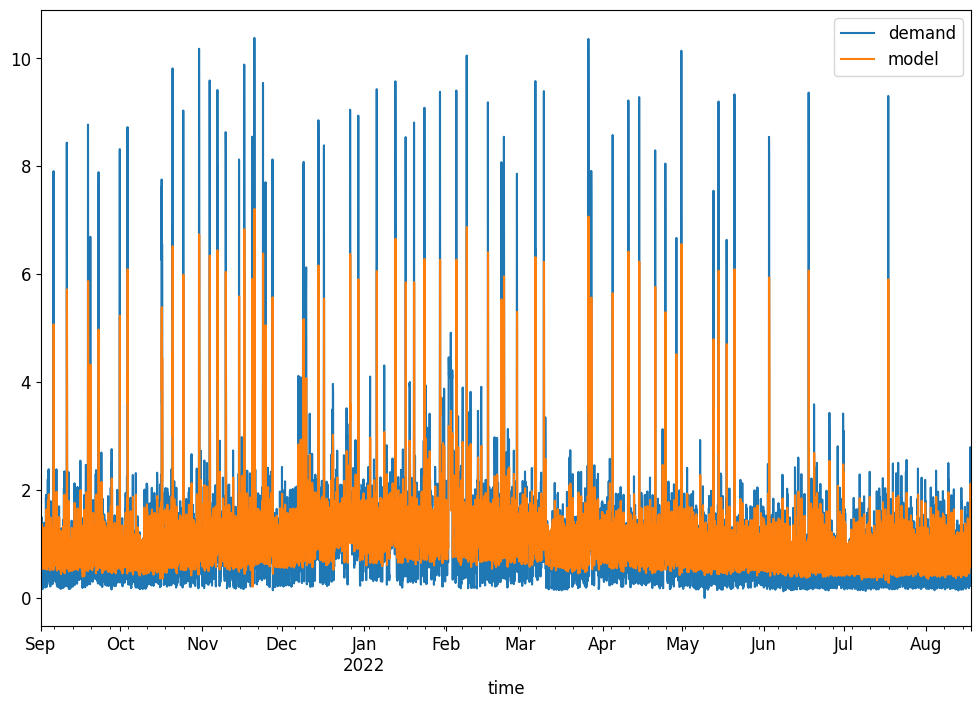

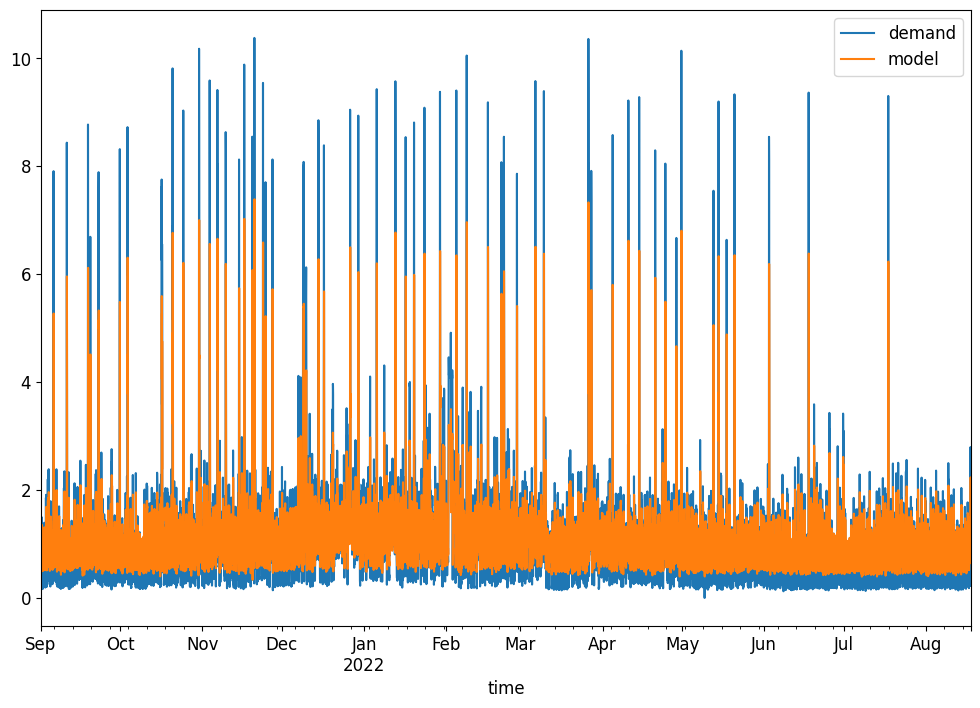

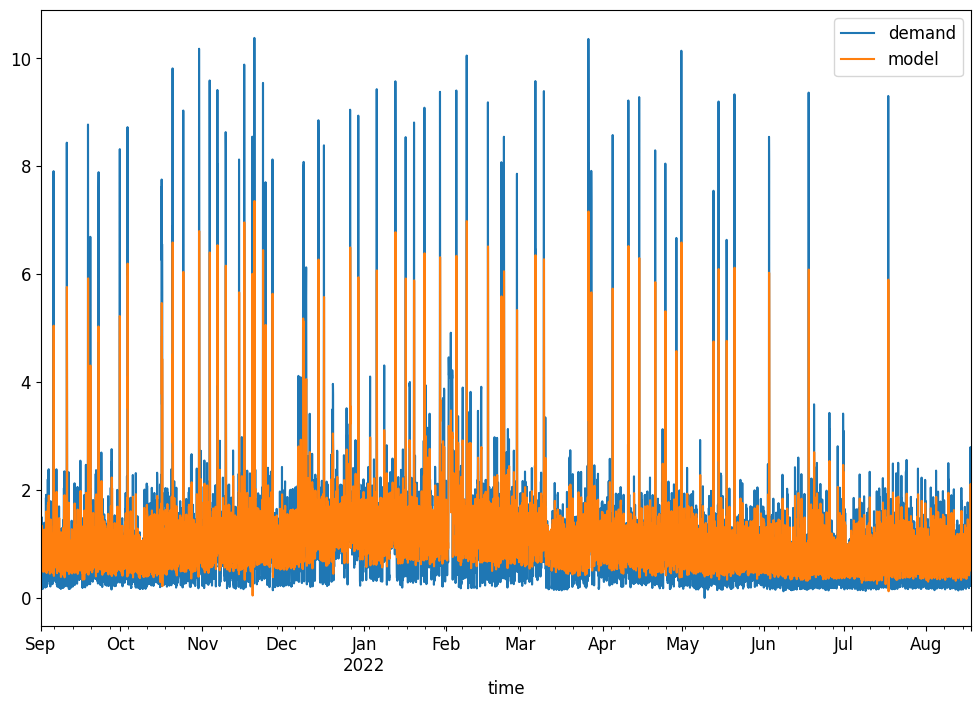

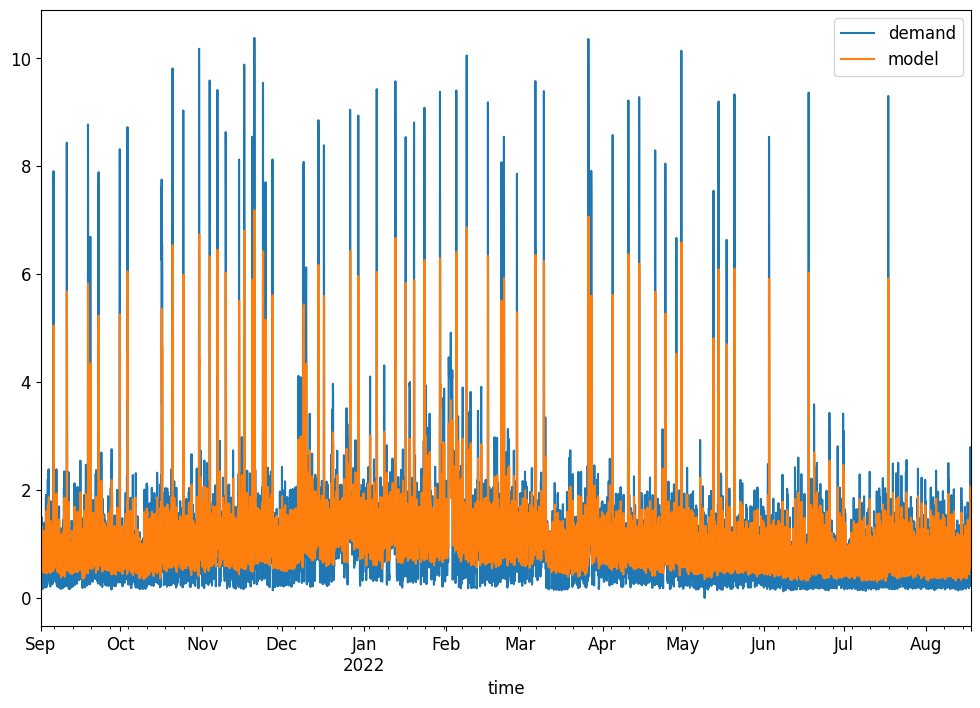

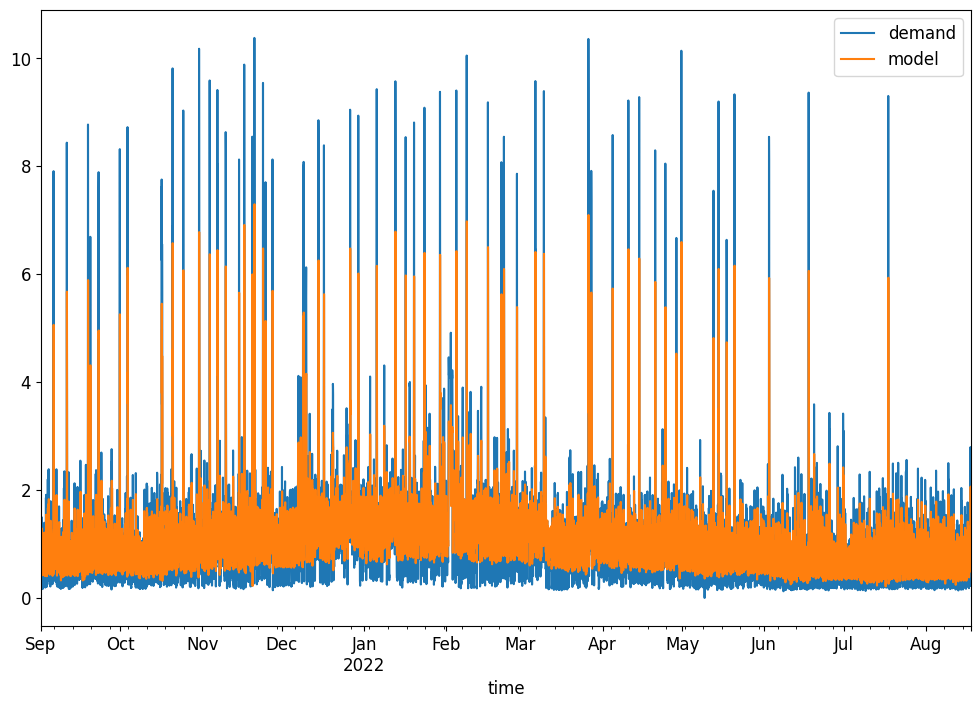

In [42]:
from statsmodels.tsa.arima.model import ARIMA

df_train.index = pd.to_datetime(df_train.index, utc=True).map(lambda x: x.tz_convert('Europe/Tallinn'))
df_train = df_train.asfreq('h')
print(df_train['demand'].index)

for i in range(0,4):
    for j in range(0,4):
        model = ARIMA(df_train['demand'],order=(i,0,j), freq='h')
        history = model.fit()

        df_train['model'] = history.predict()
        df_train[['demand','model']].plot(figsize=(12,8));
        df_train['abs_error'] = np.abs(df_train['demand'] - df_train['model'])
        print(f'ARMA({i},0,{j}) MAE = {df_train['abs_error'].mean()}')

In [19]:
print(history.summary())

                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                 8424
Model:                 ARIMA(5, 0, 7)   Log Likelihood              -10461.376
Date:                Fri, 13 Dec 2024   AIC                          20950.752
Time:                        19:48:20   BIC                          21049.295
Sample:                             0   HQIC                         20984.395
                               - 8424                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9178      0.287      3.196      0.001       0.355       1.481
ar.L1         -0.7805      0.081     -9.690      0.000      -0.938      -0.623
ar.L2          0.8303      0.081     10.197      0.0